# Visual Model Assembly 

In [11]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.10.0


In [12]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:
import os
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output

Read in data which has already been pre processed 

In [14]:
train_data = pd.read_csv('data_csv/train.csv')
test_data = pd.read_csv('data_csv/test.csv')
val_data = pd.read_csv('data_csv/val.csv')

The function below is necessary to interpret our pixel input as an image 

In [15]:
# Function to convert pixel string to image and save it
def save_image(pixel_str, filename):
    pixel_values = list(map(int, pixel_str.split()))
    num_pixels = int(len(pixel_values) ** 0.5)
    image_array = np.array(pixel_values).reshape(num_pixels, num_pixels)
    image = Image.fromarray(image_array.astype(np.uint8))
    image.save(filename)

The function below creates a directory with subdirectories for each emotion. Jpgs of each emotions are saved in each directory.

In [16]:
def create_jpgs(output_dir, df):

    # Create directories for each emotion label
    for emotion_label in df['emotion'].unique():
        emotion_dir = os.path.join(output_dir, str(emotion_label))
        os.makedirs(emotion_dir, exist_ok=True)

    # Save images to respective directories
    for index, row in df.iterrows():
        emotion_label = row['emotion']
        pixel_str = row['pixels']
        image_filename = f"{index}.jpg"  # Assuming image filenames are based on index
        output_path = os.path.join(output_dir, str(emotion_label), image_filename)
        save_image(pixel_str, output_path)

    print("Images saved successfully!")


Directories are created and populated for training, validation, and testing data. This is necessary for the model training pipeline

In [17]:
create_jpgs('data_jpg/train', train_data)
create_jpgs('data_jpg/test', test_data)
create_jpgs('data_jpg/val', val_data)

Images saved successfully!
Images saved successfully!
Images saved successfully!


Below we create generators for both training and testing processes. These facilitate the reading in and manipulation of images. 

In [18]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

The following constants define aspects of our architecture, training process, and overall model. 

In [19]:
# Constants 
SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 30
FINE_TUNING_EPOCHS = 20
LR = 0.01
NUM_CLASSES = 7
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

In [20]:
train_generator = train_datagen.flow_from_directory(directory = 'data_jpg/train',
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = 'data_jpg/test',
                                                        target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                        batch_size = BATCH_SIZE,
                                                        shuffle  = True , 
                                                        color_mode = "rgb",
                                                        class_mode = "categorical",
                                                        subset = "validation",
                                                        seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = 'data_jpg/val',
                                                target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                )

Found 20099 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.
Found 3590 images belonging to 7 classes.


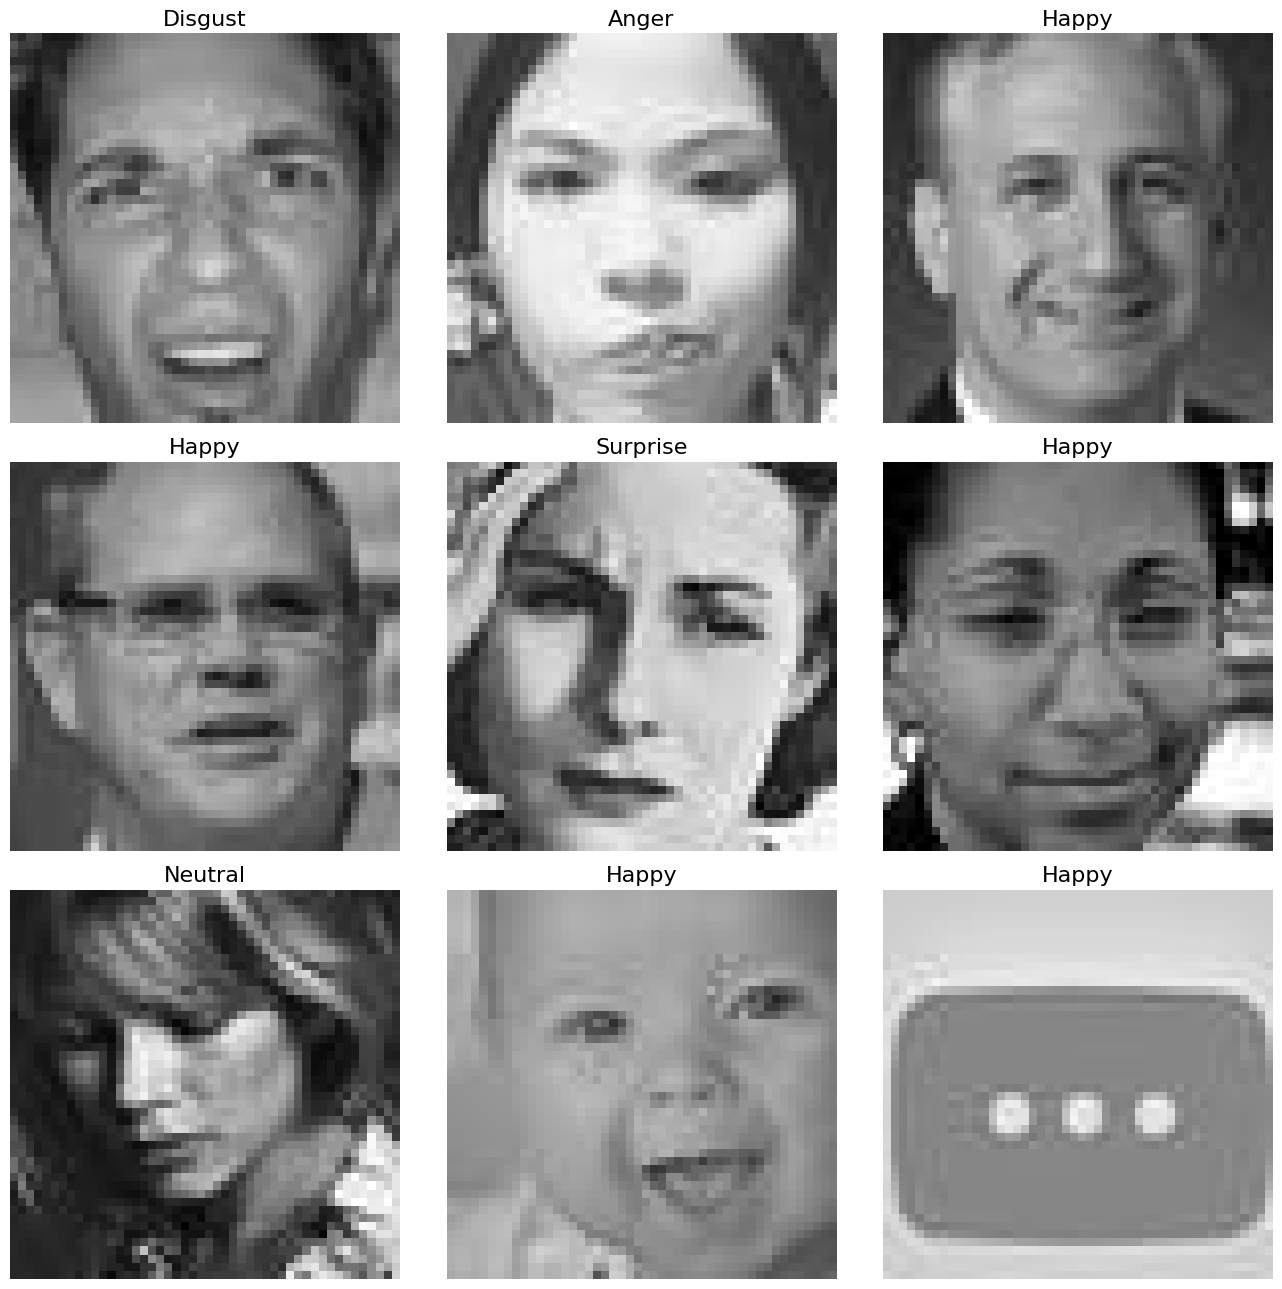

In [21]:
# Helper Functions
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)
    
def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

img_datagen = ImageDataGenerator(rescale = 1./255)
img_generator = img_datagen.flow_from_directory(directory = 'data_jpg/train',
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )
clear_output()

images, classes = next(img_generator)
class_idxs = np.argmax(classes, axis=-1) 
labels = [CLASS_LABELS[idx] for idx in class_idxs]
display_nine_images(images, labels)

In [22]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet169(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.1), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

In [23]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 densenet169 (Functional)    (None, 1, 1, 1664)        12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               426240    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                             

In [24]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

history = model.fit(x = train_generator,
                    epochs = EPOCHS ,
                    validation_data = validation_generator , 
                    callbacks= [earlyStoppingCallback])

history = pd.DataFrame(history.history)

Epoch 1/30
315/315 [==============================] - 66s 188ms/step - loss: 10.6021 - accuracy: 0.2392 - val_loss: 6.2100 - val_accuracy: 0.2535
Epoch 2/30
315/315 [==============================] - 15s 47ms/step - loss: 4.2940 - accuracy: 0.2504 - val_loss: 3.0430 - val_accuracy: 0.2626
Epoch 3/30
315/315 [==============================] - 15s 47ms/step - loss: 2.5073 - accuracy: 0.2505 - val_loss: 2.1807 - val_accuracy: 0.2535
Epoch 4/30
315/315 [==============================] - 15s 48ms/step - loss: 1.9970 - accuracy: 0.2546 - val_loss: 1.8930 - val_accuracy: 0.2682
Epoch 5/30
315/315 [==============================] - 15s 49ms/step - loss: 1.8500 - accuracy: 0.2549 - val_loss: 1.8135 - val_accuracy: 0.2723
Epoch 6/30
315/315 [==============================] - 15s 49ms/step - loss: 1.8056 - accuracy: 0.2613 - val_loss: 1.7944 - val_accuracy: 0.2668
Epoch 7/30
315/315 [==============================] - 15s 49ms/step - loss: 1.7922 - accuracy: 0.2611 - val_loss: 1.7825 - val_accurac

In [25]:
# Un-Freezing the feature extraction layers for fine tuning 
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)
history = history.append(pd.DataFrame(history_.history) , ignore_index=True)

Epoch 1/20
315/315 [==============================] - 21s 49ms/step - loss: 1.7386 - accuracy: 0.3034 - val_loss: 1.7264 - val_accuracy: 0.3087
Epoch 2/20
315/315 [==============================] - 14s 44ms/step - loss: 1.7391 - accuracy: 0.3038 - val_loss: 1.7252 - val_accuracy: 0.3080
Epoch 3/20
315/315 [==============================] - 14s 44ms/step - loss: 1.7332 - accuracy: 0.3081 - val_loss: 1.7235 - val_accuracy: 0.3059
Epoch 4/20
315/315 [==============================] - 14s 44ms/step - loss: 1.7346 - accuracy: 0.3065 - val_loss: 1.7227 - val_accuracy: 0.3080
Epoch 5/20
315/315 [==============================] - 14s 45ms/step - loss: 1.7353 - accuracy: 0.3013 - val_loss: 1.7222 - val_accuracy: 0.3066
Epoch 6/20
315/315 [==============================] - 14s 45ms/step - loss: 1.7336 - accuracy: 0.3053 - val_loss: 1.7211 - val_accuracy: 0.3101
Epoch 7/20
315/315 [==============================] - 14s 45ms/step - loss: 1.7339 - accuracy: 0.3029 - val_loss: 1.7216 - val_accuracy:

AttributeError: 'DataFrame' object has no attribute 'append'

In [26]:
x = px.line(data_frame= history , y= ["accuracy" , "val_accuracy"] ,markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [27]:
x = px.line(data_frame= history , 
            y= ["loss" , "val_loss"] , markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [28]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

57/57 [==============================] - 2s 15ms/step


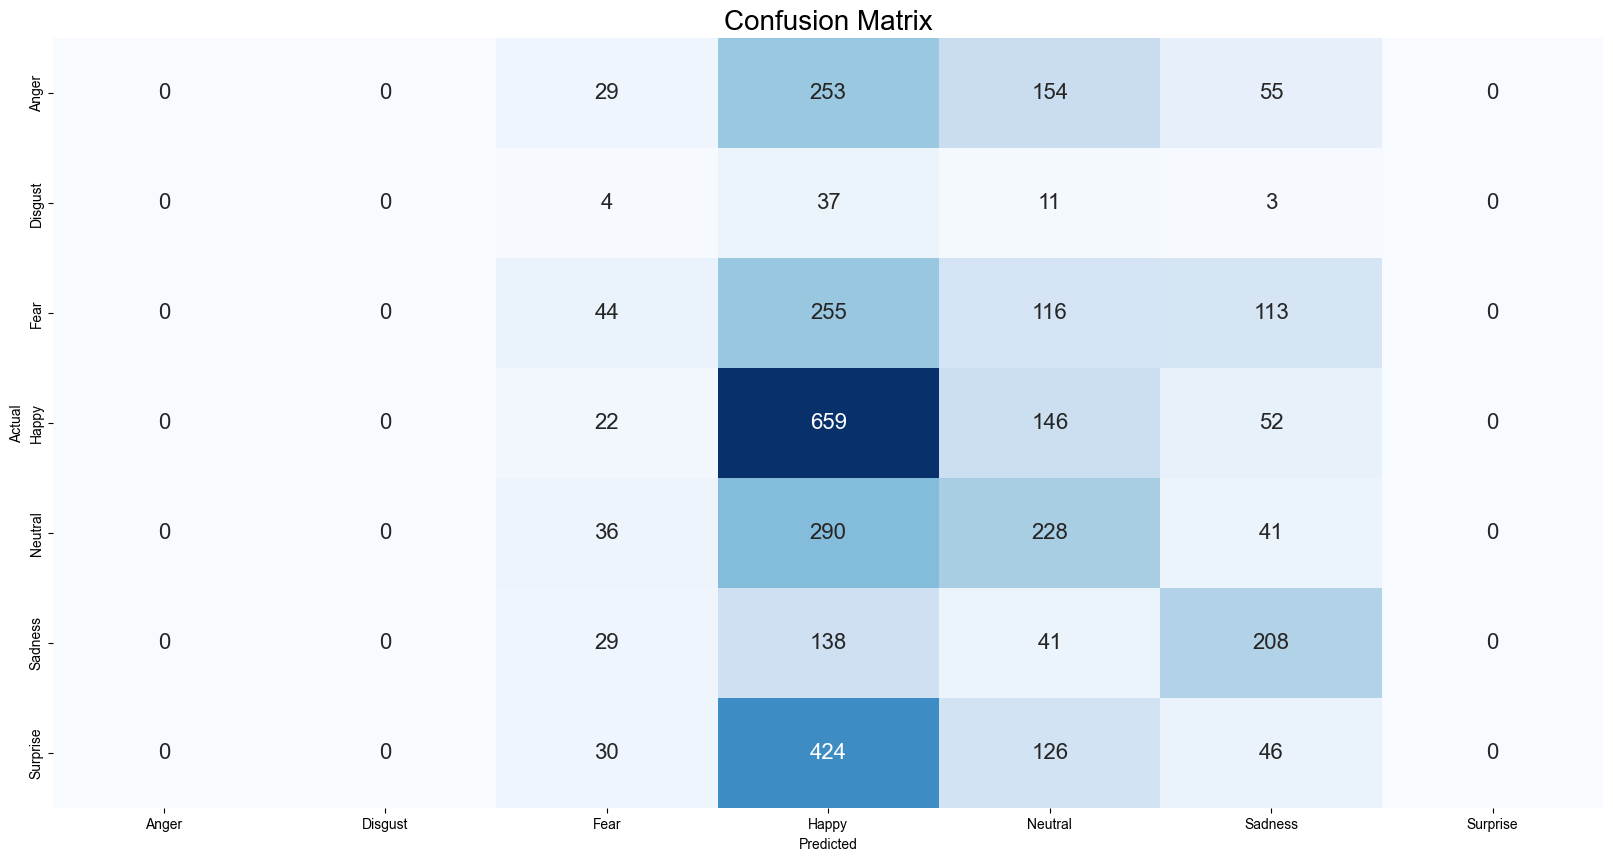

In [29]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [30]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       491
           1       0.00      0.00      0.00        55
           2       0.23      0.08      0.12       528
           3       0.32      0.75      0.45       879
           4       0.28      0.38      0.32       595
           5       0.40      0.50      0.45       416
           6       0.00      0.00      0.00       626

    accuracy                           0.32      3590
   macro avg       0.18      0.25      0.19      3590
weighted avg       0.20      0.32      0.23      3590



c:\Users\Andres\Documents\GitHub\Senior_Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Andres\Documents\GitHub\Senior_Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Andres\Documents\GitHub\Senior_Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



ROC AUC score: 0.7215622098421541


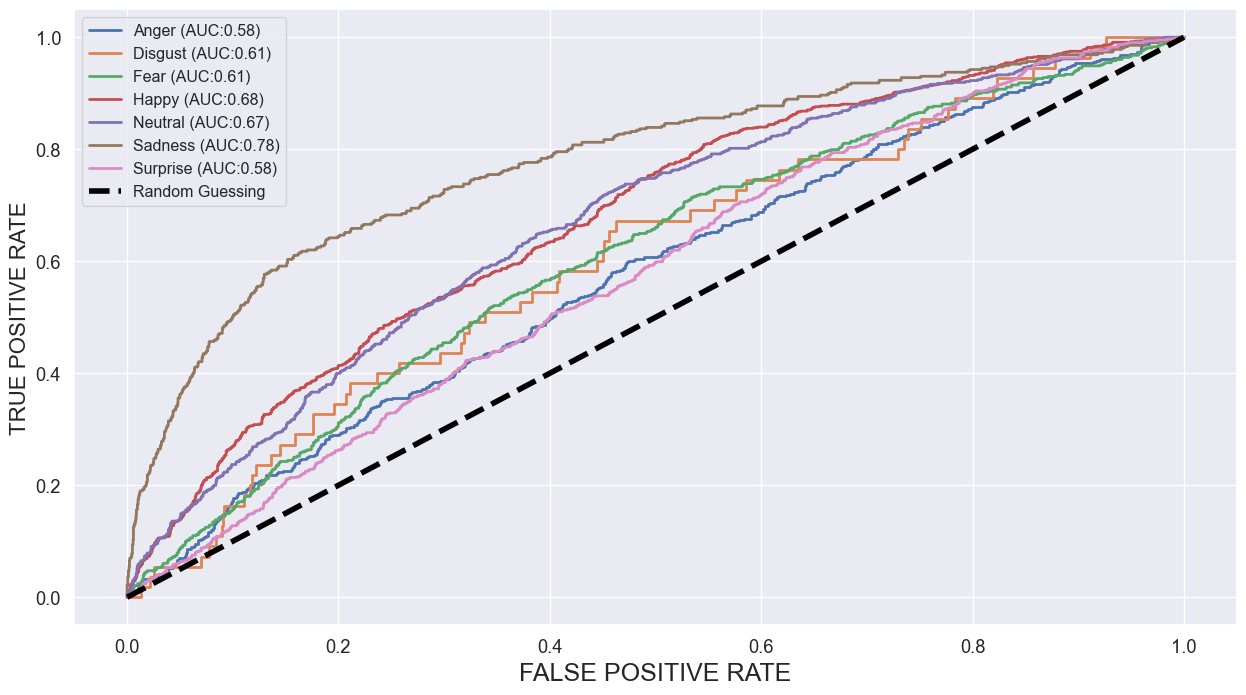

In [31]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [32]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))

ROC-AUC Score  =  0.6426422278903566


In [33]:
model.save('model/secondmodel.keras')

In [34]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input
import tensorflow as tf
import numpy as np

In [35]:
loaded_model = tf.keras.models.load_model('model/secondmodel.keras')

In [36]:
# predicting user input 
# Load and preprocess the image
img_path = '../../User/split_input/face_3.jpg'
img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = image.img_to_array(img)
img_array_expanded_dims = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_array_expanded_dims)

In [37]:
prediction = loaded_model.predict(img_preprocessed)
print(prediction)
predicted_class = np.argmax(prediction, axis=1)
print("Predicted class:", predicted_class)

1/1 [==============================] - 1s 1s/step
[[0. 0. 1. 0. 0. 0. 0.]]
Predicted class: [2]
